# Imports

In [1]:
#basic libaries
import pandas as pd
import numpy as np

# visulalization libaris
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")
import plotly.express as px

#preproccesing libaries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV , train_test_split as split
from sklearn.metrics import accuracy_score, plot_roc_curve,confusion_matrix,classification_report,plot_confusion_matrix,plot_precision_recall_curve,f1_score,roc_curve
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator

#warnings libaries
import warnings
warnings.filterwarnings('ignore')


In [2]:
#extract dataset from your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path='/content/drive/MyDrive/important notebook/healthcare-dataset-stroke-data.csv'

df = pd.read_csv(path)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#Data cleaning

In [4]:
#lowercase the columns name and clean wasted spaces
df=df.rename(lambda col: col.lower(), axis=1).rename(lambda col: col.strip(), axis=1)

#drop columns
df=df.drop(columns=['id','residence_type'],axis=1)

#drop rows - check EDA
df=df[df['gender']!='Other']

df['ever_married']=df['ever_married'].map({'Yes': 1, 'No': 0})

In [ ]:
def feature_data(df):
    #print(f"shape: {df.shape}")
    table=pd.DataFrame(df.dtypes,columns=['type']).reset_index()
    table['features']=table['index']
    table=table[['features','type']]
    table['%nulls']=df.isnull().sum().values/len(df)
    table['nuniques']=df.nunique().values
    table['%unique']=df.nunique().values/len(df)
    
    return table


feature_data(df)


,features,type,%nulls,nuniques,%unique
0,gender,object,0.000000,2,0.000391
1,age,float64,0.000000,104,0.020356
2,hypertension,int64,0.000000,2,0.000391
3,heart_disease,int64,0.000000,2,0.000391
4,ever_married,int64,0.000000,2,0.000391
5,work_type,object,0.000000,5,0.000979
6,avg_glucose_level,float64,0.000000,3978,0.778626
7,bmi,float64,0.039342,418,0.081816
8,smoking_status,object,0.000000,4,0.000783
9,stroke,int64,0.000000,2,0.000391


In [ ]:
!pip install sweetviz
import sweetviz as sv

                                             |          | [  0%]   00:00 -> (? left)


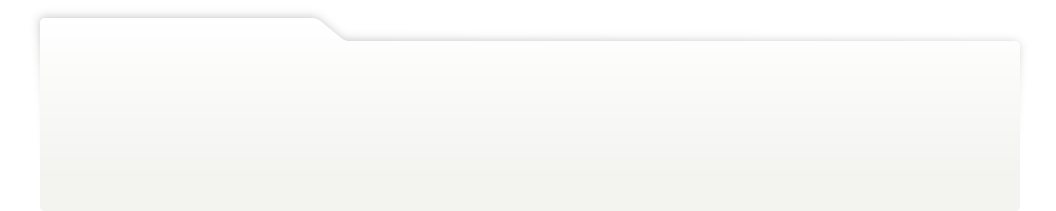
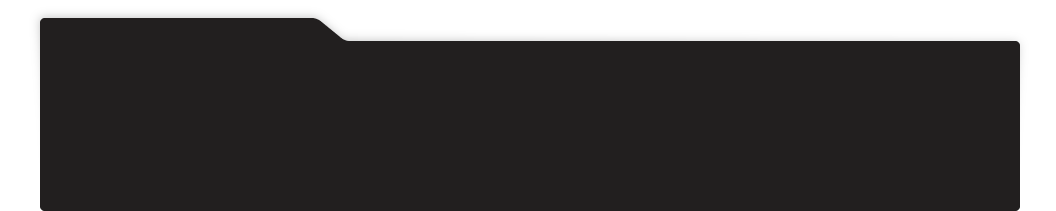
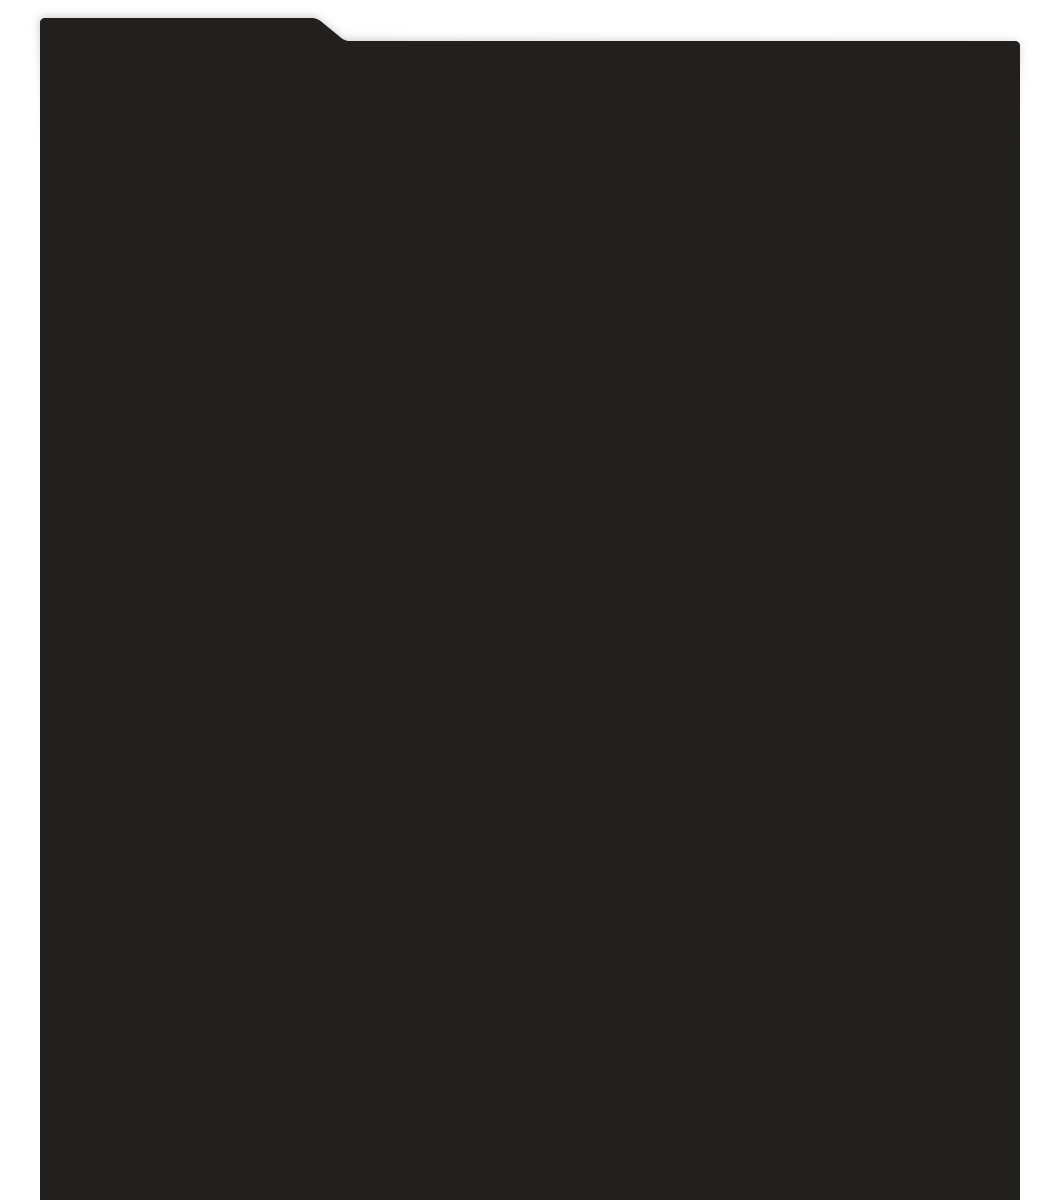
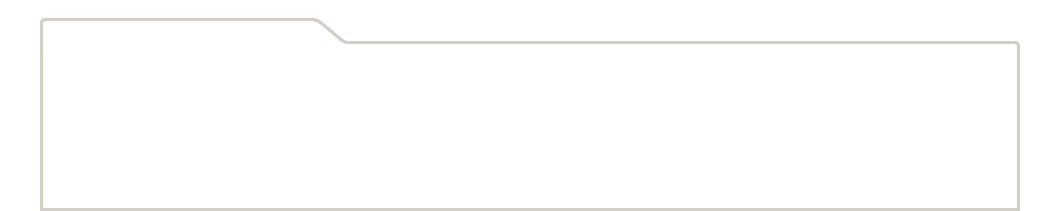
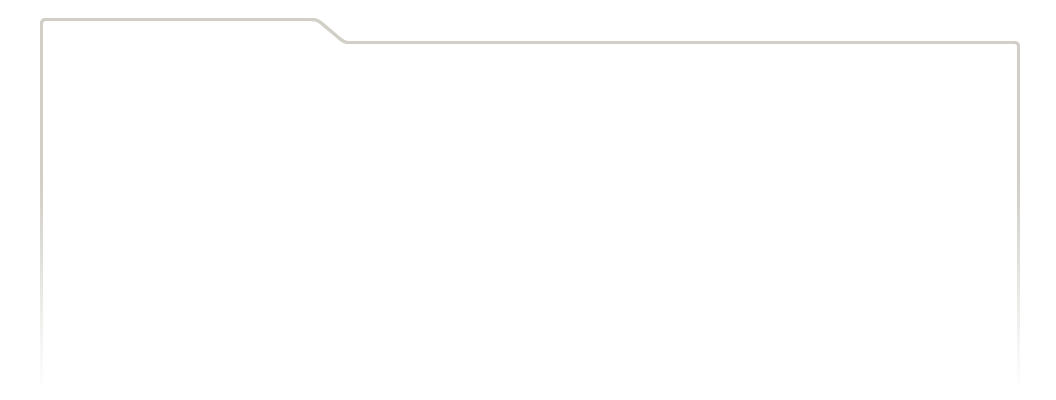
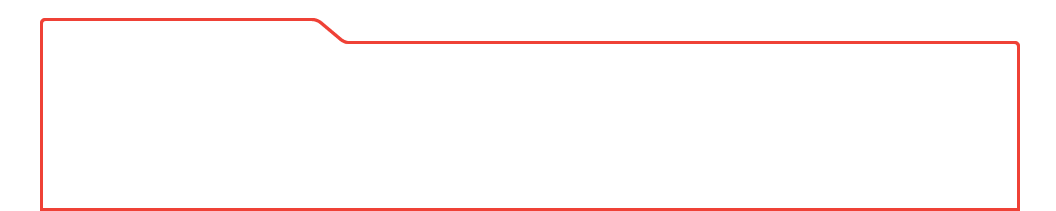
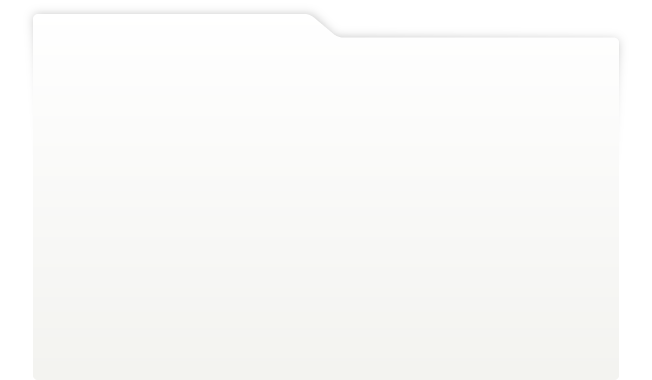
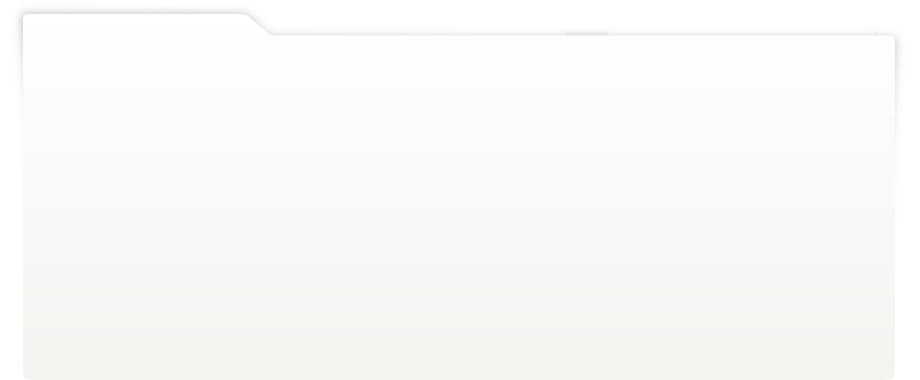
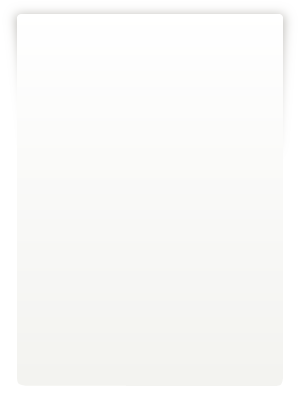
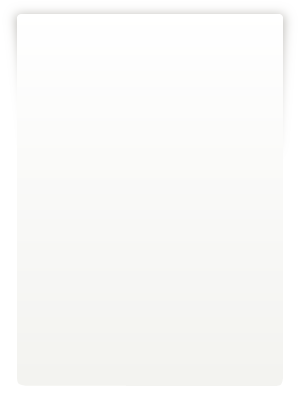
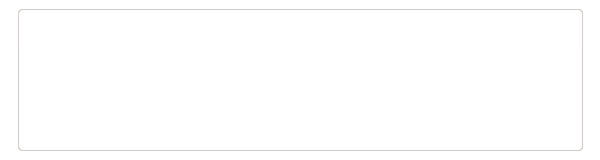
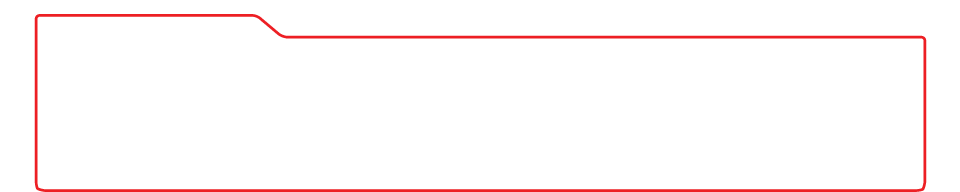
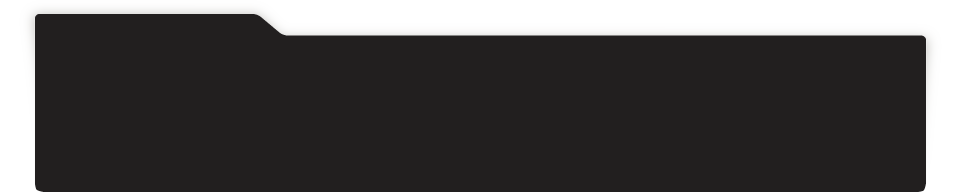
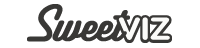
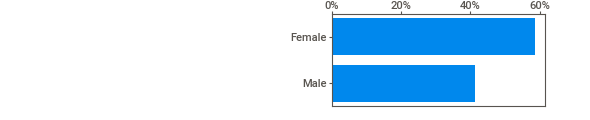
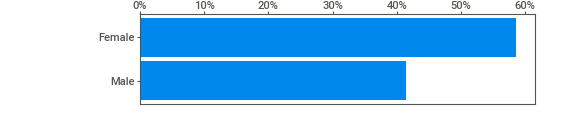
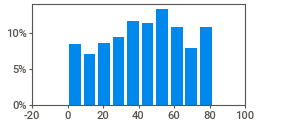
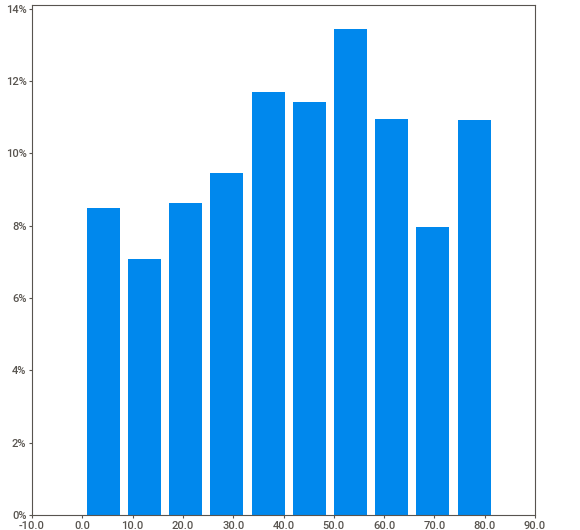
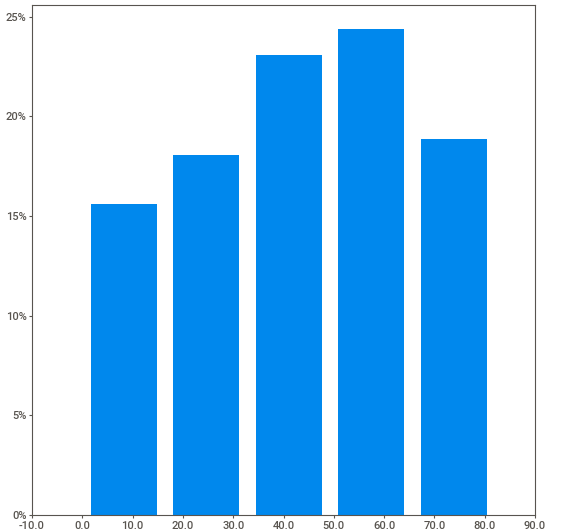
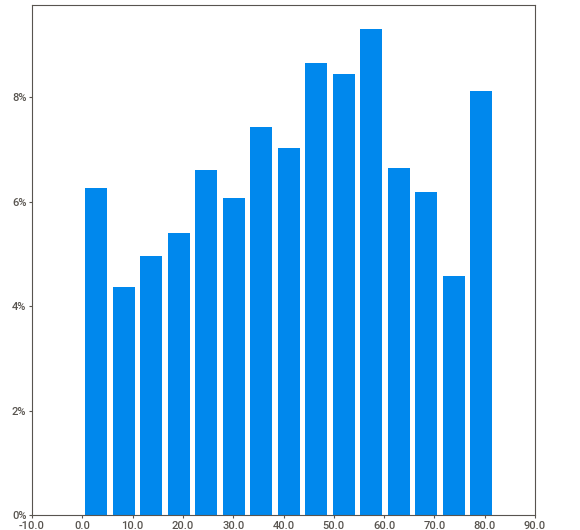
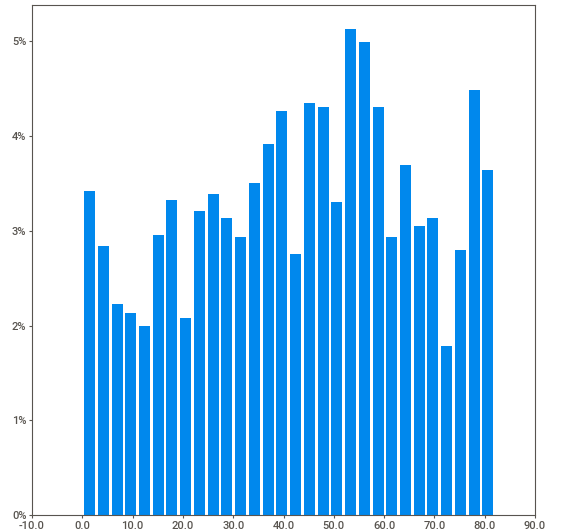
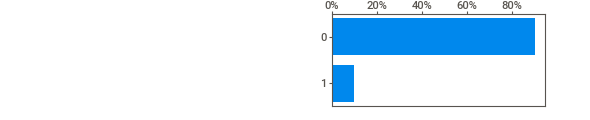
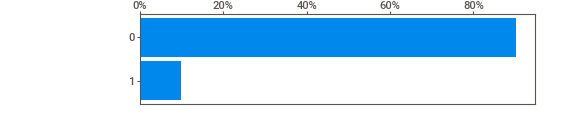
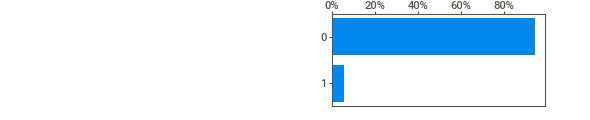
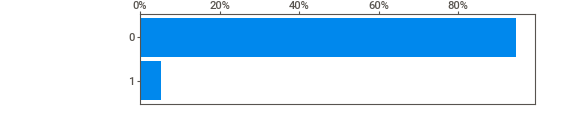
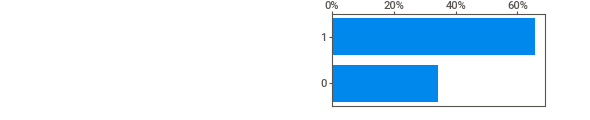
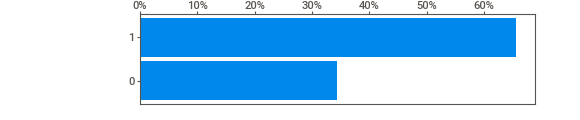
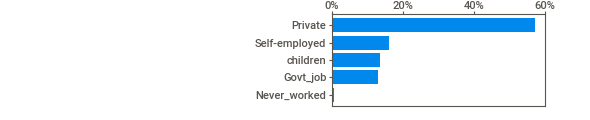
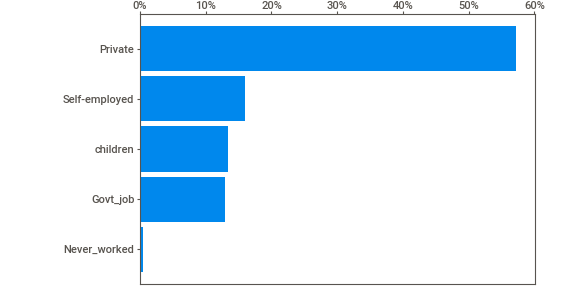
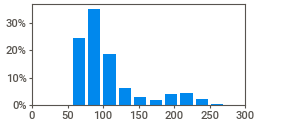
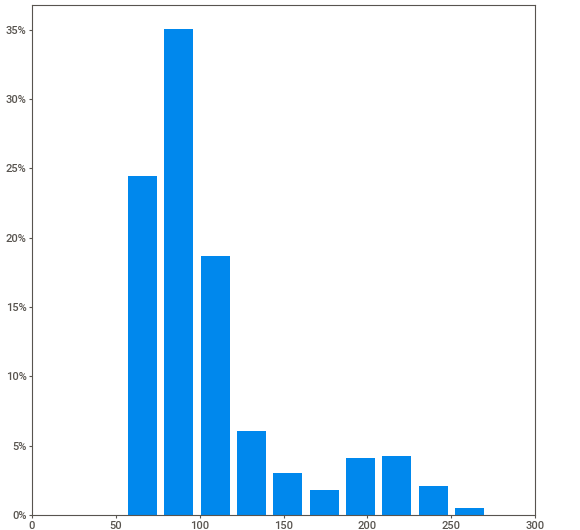
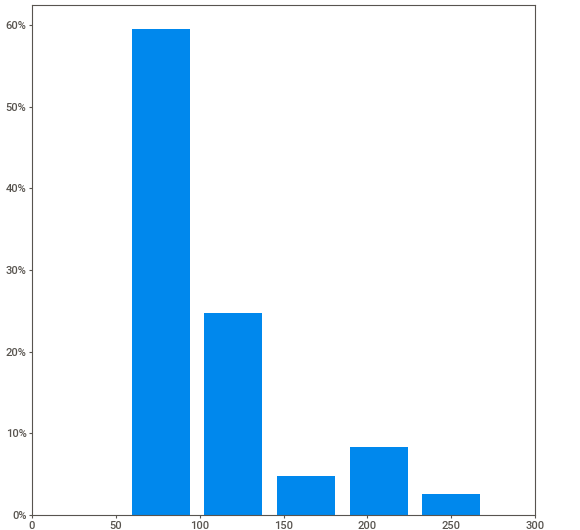
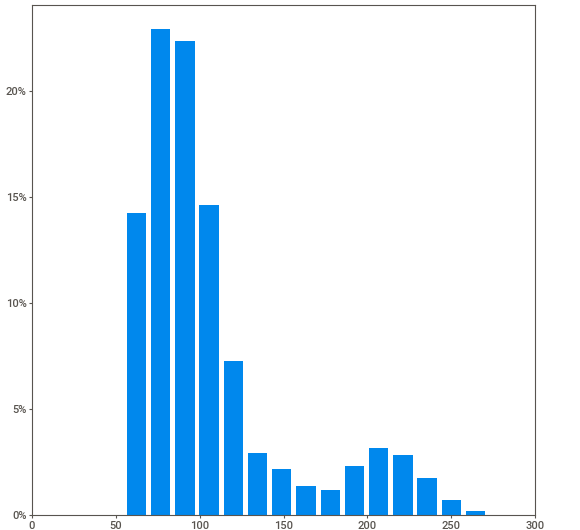
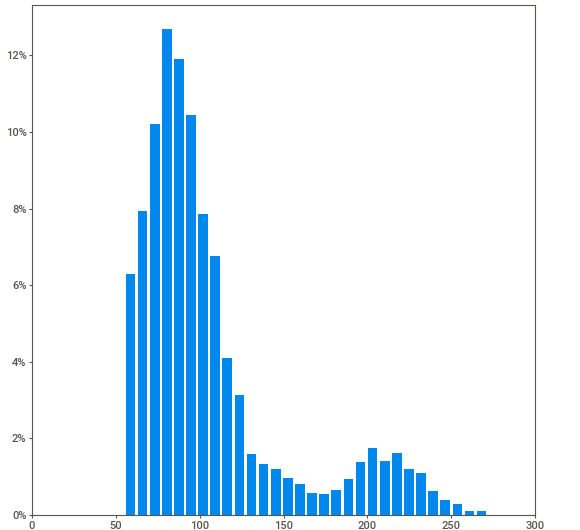
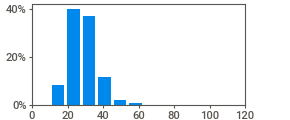
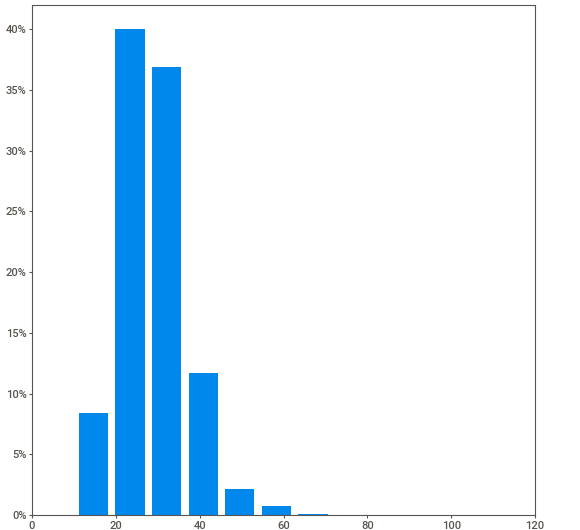
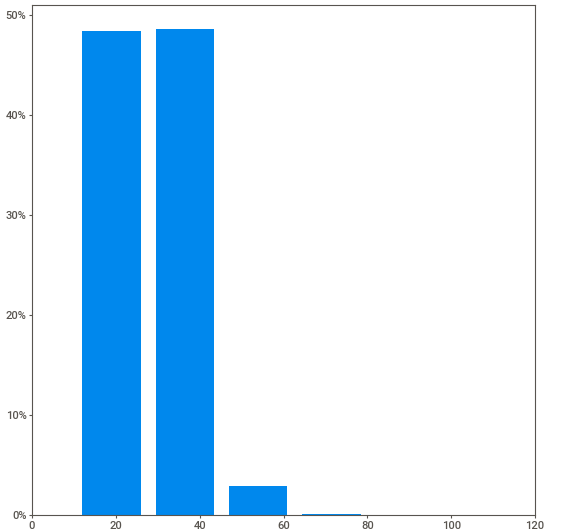
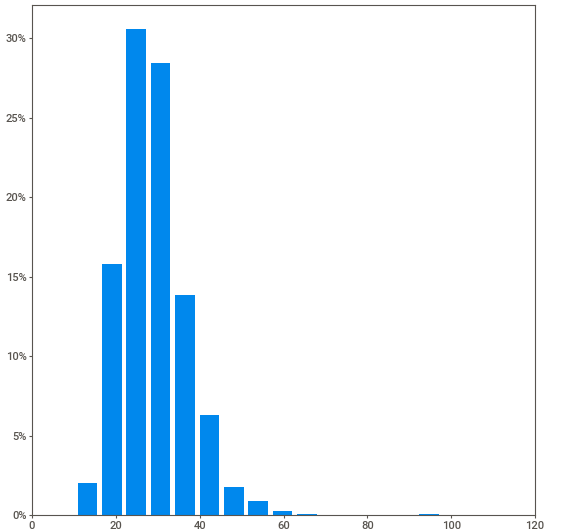
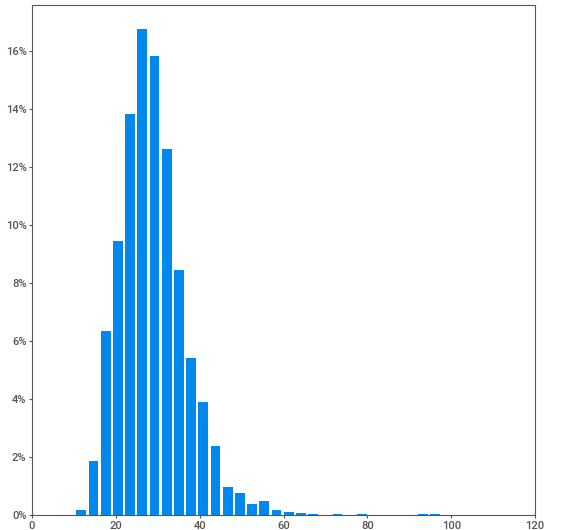
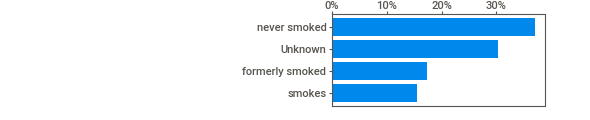
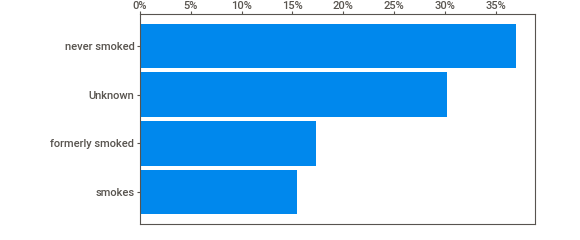
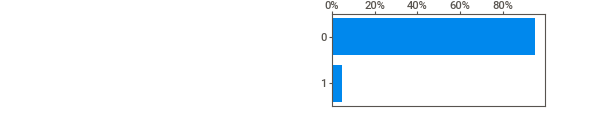
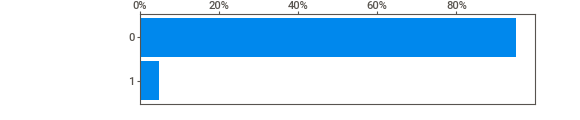
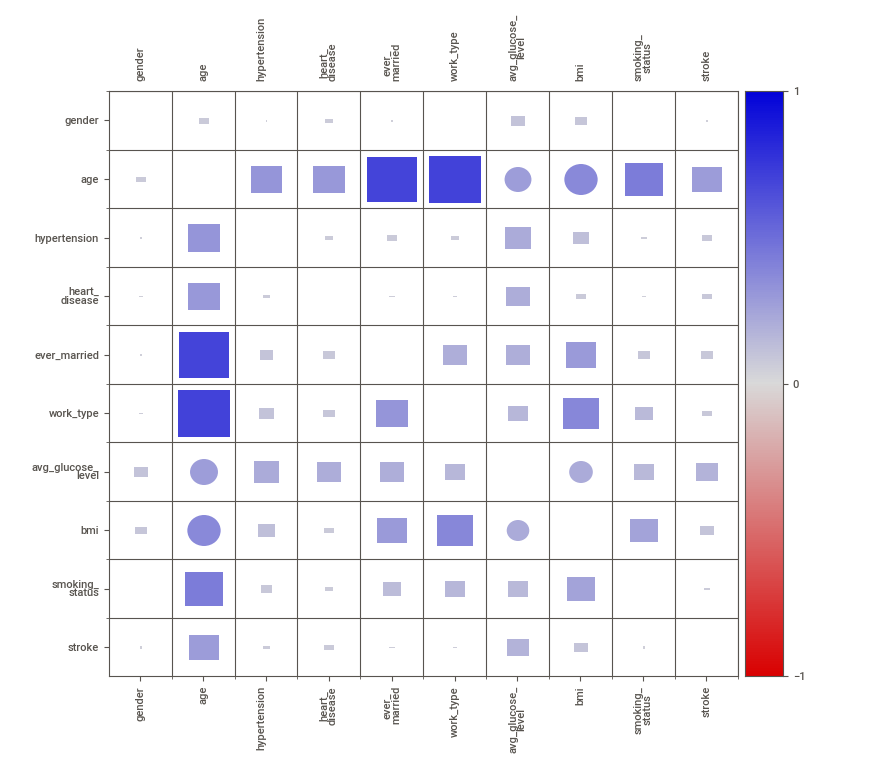
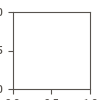

In [ ]:
my_report = sv.analyze(df)
my_report.show_notebook(  w=None, 
                h=None, 
                scale=None,
                layout='widescreen',
                filepath=None)

# EDA

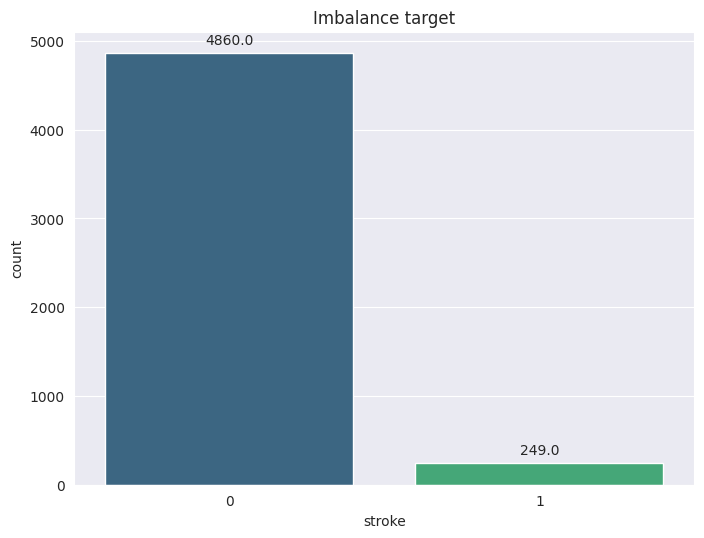

In [ ]:
plt.figure(figsize=(8,6),dpi=100)
ax=sns.countplot(data=df, x='stroke', palette='viridis')

plt.title('Imbalance target')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
    (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', 
    xytext = (0, 9), 
    textcoords = 'offset points')

plt.show()

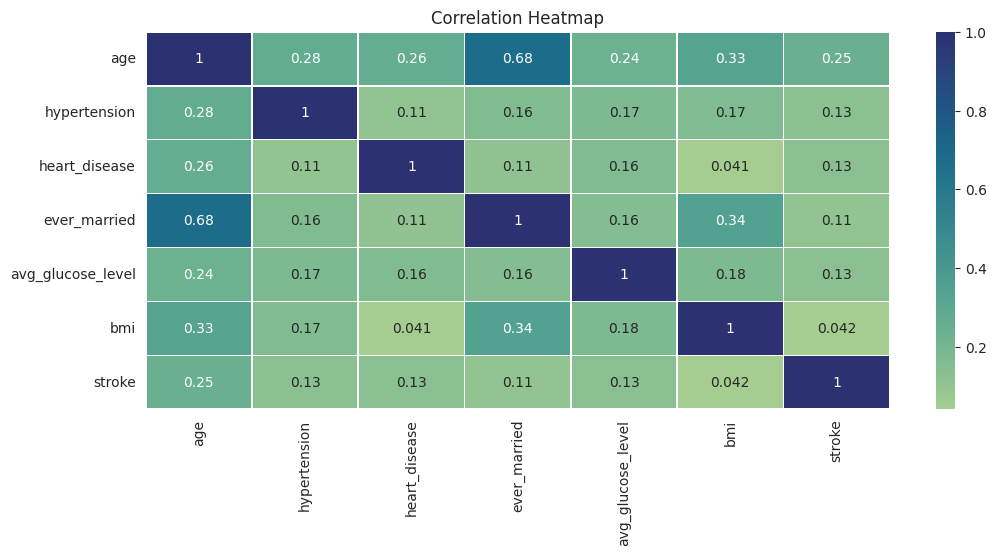

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
plt.title("Correlation Heatmap")
sns.heatmap(data=df.corr(), annot=True, linewidth=0.5 ,cmap="crest")
plt.show()

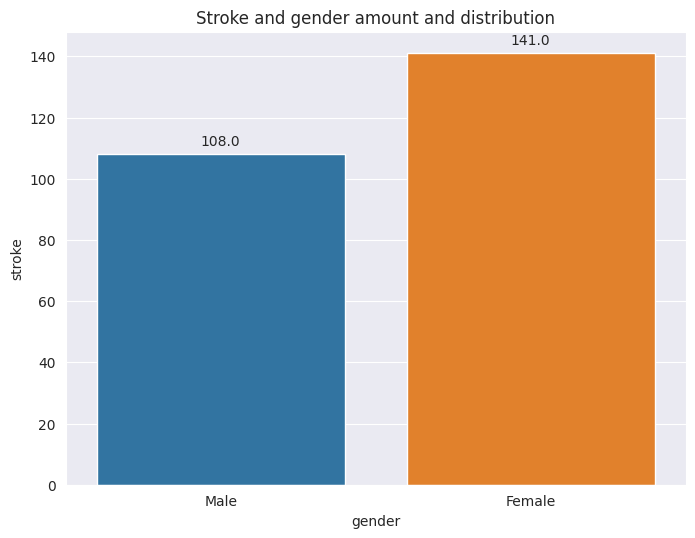

In [ ]:
plt.figure(figsize=(8,6),dpi=100)
ax=sns.barplot(data=df , x='gender' , y='stroke', ci=0 , estimator=sum)
plt.title('Stroke and gender amount and distribution')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
    (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', 
    xytext = (0, 9), 
    textcoords = 'offset points')

plt.show()

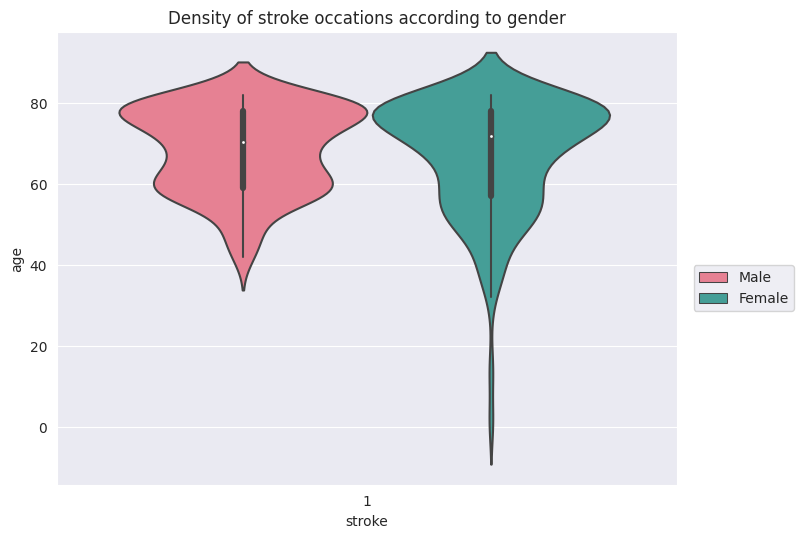

Important Insight: this graph shows that Males on our data never diagnosed with stroke under age of 40 while Females can be diagnosed earlier


In [ ]:
stroke_group=df[df['stroke']==1]
plt.figure(figsize=(8,6),dpi=100)
plt.title('Density of stroke occations according to gender')
sns.violinplot(data=stroke_group, x='stroke' , y='age', hue='gender', palette='husl')
plt.legend(bbox_to_anchor=(1.2,0.5))
plt.show()

print('Important Insight: this graph shows that Males on our data never diagnosed with stroke under age of 40 while Females can be diagnosed earlier')

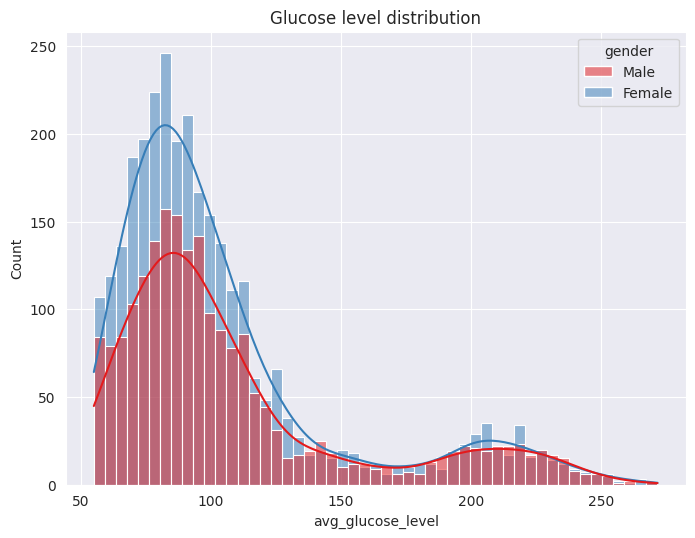

In [ ]:
plt.figure(figsize=(8,6),dpi=100)
sns.histplot(data=df, x='avg_glucose_level', kde=True, hue='gender', palette='Set1')
plt.title('Glucose level distribution')
plt.show()

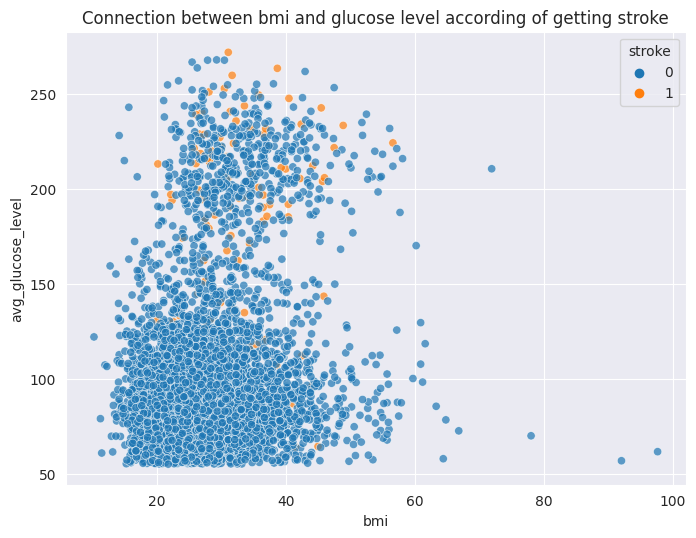

In [ ]:
plt.figure(figsize=(8,6),dpi=100)
sns.scatterplot(data=df, x='bmi', y='avg_glucose_level', hue='stroke', alpha=0.7)
plt.title('Connection between bmi and glucose level according of getting stroke')
plt.show()

# Preproccesing

In [5]:
#seprating the target from the features
FeatureCols = df.drop(['stroke'], axis='columns').columns
# X=df.drop(columns=['stroke'],axis=1)
X=df[FeatureCols]
y=df['stroke']


#spliting the data before training
X_train,X_test,y_train,y_test=split(X,y,test_size=0.3, shuffle=True, random_state=42)


In [6]:
class MissingValuesFiller(TransformerMixin, BaseEstimator):
  """filling in the bmi nulls with data learned from training """
  def __init__(self):
    super().__init__()
    self.bmi="bmi"

  def fit(self, X, y= None):
    self.median_=X[self.bmi].median()
    return self

  def transform(self, X):
    frame=X.copy()
    frame[self.bmi]=frame[self.bmi].fillna(self.median_)
    return frame


In [7]:

class MyOneHotEncoder(TransformerMixin, BaseEstimator):
  """one_hot_encoder - count features like dummy variables"""
  def __init__(self):
    super().__init__()
    self.ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')

  def fit(self,X,y=None):
    X_obj=X.select_dtypes("object")
    self.ohe.fit(X_obj)

    return self

  def transform(self, X):
    output=X.copy()
    string_features=pd.DataFrame(self.ohe.transform(output.select_dtypes("object")))
    numerical_features = output.select_dtypes(np.number)

    return np.concatenate([string_features,numerical_features], axis=1)

In [8]:
#pipeline/feature_union
scaler=MinMaxScaler()

my_pipe=Pipeline(steps=[("filler",MissingValuesFiller()),
                          ("ohe",MyOneHotEncoder()),
                          ("scaler",scaler)])

X_train_model=my_pipe.fit_transform(X_train)
X_test_model=my_pipe.transform(X_test)
#X_train_model, X_test_model are the final matrix we should use with running the models

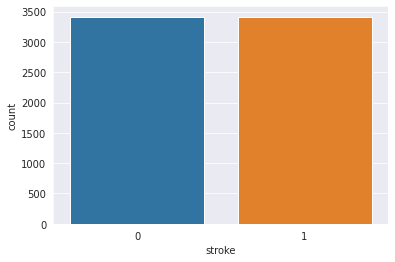

In [9]:
from imblearn.over_sampling import SMOTE
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
smote = SMOTE(random_state=42)
X_train_model, y_train= smote.fit_resample(X_train_model, y_train)

sns.countplot(y_train,x='stroke')

In [ ]:
# #pipeline and FeatureUnion

# features_after_transformation=FeatureUnion(transformer_list=[('filler',MissingValuesFiller()),
#                                                              ('ohe',MyOneHotEncoder())])

# from sklearn.linear_model import LogisticRegression
# log=LogisticRegression()

# my_pipe=Pipeline(steps=[('features',features_after_transformation),
#                         ('model',log)])
# #complete the pipeline...


#Models

## XGBoost

In [10]:
from xgboost import XGBClassifier

In [34]:
my_xgb=XGBClassifier(random_state=42)

learning_rate=[0.01,0.05,0.1,0.25]
max_depth=[2,3,5,7,10]
n_estimators=[50,100,200]
gamma=[0.0,0.1,0.2,0.3,0.4]
scale_pos_weight=[1,3,5]
max_features=[0.25,0.5,0.75,1]
min_samples_split=[3,5,7,10,20]
subsample=[0.5,0.8,1]

f_beta_score = make_scorer(fbeta_score, beta=2)


xgb_params={'learning_rate': learning_rate,
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'gamma': gamma,
            'subsample':subsample,
            'scale_pos_weight': scale_pos_weight,
            'min_samples_split':min_samples_split,
            'max_features': max_features}


xgb_model=RandomizedSearchCV(my_xgb,xgb_params,n_iter=50,scoring=f_beta_score,cv=4)


In [35]:
xgb_model.fit(X_train_model,y_train)

RandomizedSearchCV(cv=4, estimator=XGBClassifier(random_state=42), n_iter=50,
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.25],
                                        'max_depth': [2, 3, 5, 7, 10],
                                        'max_features': [0.25, 0.5, 0.75, 1],
                                        'min_samples_split': [3, 5, 7, 10, 20],
                                        'n_estimators': [50, 100, 200],
                                        'scale_pos_weight': [1, 3, 5],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring=make_scorer(fbeta_score, beta=0.5))

In [36]:
y_pred=xgb_model.predict(X_test_model)

In [37]:
xgb_model.best_params_

{'subsample': 1,
 'scale_pos_weight': 1,
 'n_estimators': 200,
 'min_samples_split': 7,
 'max_features': 0.5,
 'max_depth': 7,
 'learning_rate': 0.1,
 'gamma': 0.2}

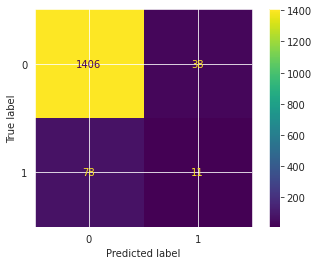

In [38]:
plot_confusion_matrix(xgb_model,X_test_model,y_test)

In [39]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1484
           1       0.12      0.22      0.16        49

    accuracy                           0.92      1533
   macro avg       0.55      0.59      0.56      1533
weighted avg       0.95      0.92      0.93      1533



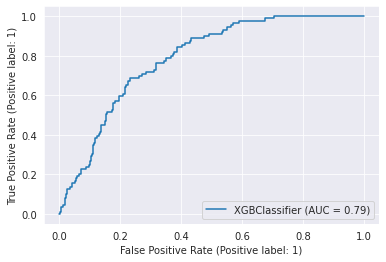

In [40]:
plot_roc_curve(xgb_model.best_estimator_,X_test_model,y_test)

## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
dt_model=DecisionTreeClassifier(random_state=42)

In [27]:
dt_model.get_params()

criterion=['gini','entropy']
max_depth=[3,5,7,10]
max_features=['sqrt','log2']
min_samples_split=[2,5,8,10]

f_beta_score = make_scorer(fbeta_score, beta=2)


tree_params={'criterion':criterion,
             'max_depth':max_depth,
             'max_features':max_features,
             'min_samples_split':min_samples_split}

tree_grid=GridSearchCV(dt_model,tree_params,scoring=f_beta_score,cv=4)

In [28]:
tree_grid.fit(X_train_model,y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 8, 10]},
             scoring=make_scorer(fbeta_score, beta=2))

In [29]:
tree_grid.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 2}

In [30]:
y_pred=tree_grid.predict(X_test_model)

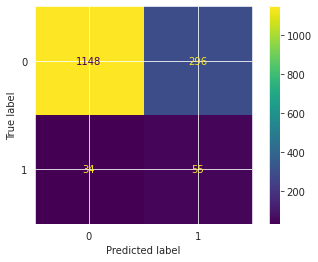

In [31]:
plot_confusion_matrix(tree_grid,X_test_model,y_test)

In [ ]:
from sklearn import tree
import graphviz

#tree.plot_tree(tree_grid.best_estimator_,filled=True)
dot_data = tree.export_graphviz(tree_grid.best_estimator_, out_file=None,filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [32]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.80      0.97      0.87      1182
           1       0.62      0.16      0.25       351

    accuracy                           0.78      1533
   macro avg       0.71      0.56      0.56      1533
weighted avg       0.75      0.78      0.73      1533



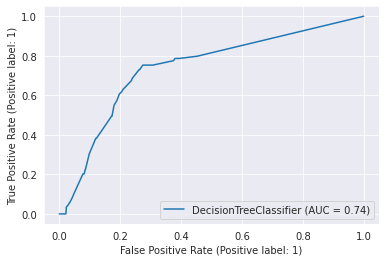

In [33]:
plot_roc_curve(tree_grid.best_estimator_,X_test_model,y_test)

## Clustering

In [41]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [42]:
def elbow_kmeans_cluster_method(df):
  """elbow method for k number of clusters"""
  ssd=[]
  for k in range(2,25):
    cluster_model=KMeans(n_clusters=k)
    cluster_model.fit(df)

    ssd.append(cluster_model.inertia_) #sum_squared_distances points--> distances from cluster center point to all other point in the cluster
  return ssd

cluster_ssd=elbow_kmeans_cluster_method(X_train_model)
#pd.Series(cluster_ssd).diff()

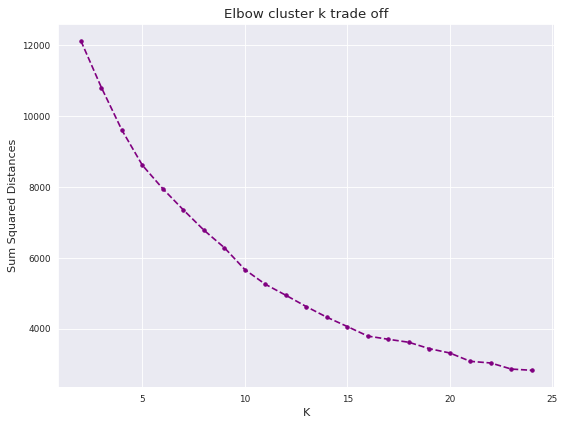

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
plt.title("Elbow cluster k trade off" )
plt.plot(range(2,25),cluster_ssd,'o--', color='purple')
plt.xlabel('K')
plt.ylabel('Sum Squared Distances')
plt.show()

## PCA

In [ ]:
def elbow_dbscan_epsilon(X):
  num_outliers_list=[]
  outlier_percent_list=[]

  for eps in np.linspace(0.001,5,100):
    my_scan=DBSCAN(eps)
    my_scan.fit(X)

    num_outliers_list.append(np.sum(my_scan.labels_== -1))

    outlier_percent=100*(np.sum(my_scan.labels_== -1))/len(my_scan.labels_)
    outlier_percent_list.append(outlier_percent)

  return num_outliers_list,outlier_percent_list


def elbow_dbscan_samples(X):
  num_outliers_list=[]
  outlier_percent_list=[]

  for n in np.arange(1,100):
    my_scan=DBSCAN(min_samples=n)
    my_scan.fit(X)

    num_outliers_list.append(np.sum(my_scan.labels_== -1))

    outlier_percent=100*(np.sum(my_scan.labels_== -1))/len(my_scan.labels_)
    outlier_percent_list.append(outlier_percent)

  return num_outliers_list,outlier_percent_list

In [ ]:
eps_outliers_list,eps_outliers_percent_list=elbow_dbscan_epsilon(X_train_model)
samp_outliers_list,samp_outliers_percent_list=elbow_dbscan_samples(X_train_model)

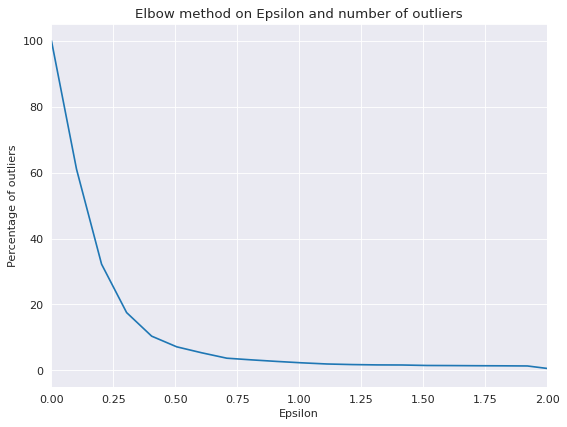

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
sns.lineplot(x= np.linspace(0.001,10,100), y=eps_outliers_percent_list)
plt.title('Elbow method on Epsilon and number of outliers')
plt.xlabel('Epsilon')
plt.ylabel('Percentage of outliers')
plt.xlim(0,2)
plt.show()

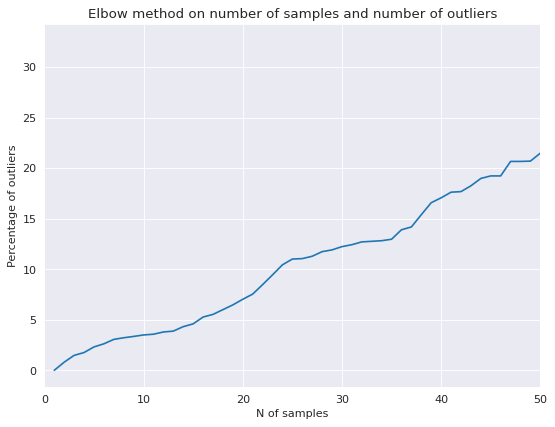

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
sns.lineplot(x= np.arange(1,100), y=samp_outliers_percent_list)
plt.title('Elbow method on number of samples and number of outliers')
plt.xlabel('N of samples')
plt.ylabel('Percentage of outliers')
plt.xlim(0,50)
plt.show()

In [43]:
class makePcaDbScan():

  def __init__(self):

    self.pca=PCA(n_components=2,random_state=42)
    self.scan=DBSCAN(eps=0.2, min_samples=5)


  def fit_pca(self,X):
    X_copy=X.copy()
    self.pca.fit(X_copy)

    return self

  def pca_clustering(self,X):

    X_copy=X.copy()
    X_pca=self.pca.transform(X)
    cluster_labels=self.scan.fit_predict(X_pca)
    pca_cluster_labels=np.insert(X_pca,values=cluster_labels,axis=1,obj=len(X_pca[0]))
    
    return pca_cluster_labels,cluster_labels

In [44]:
#main
my_pca=makePcaDbScan()

#train

my_pca.fit_pca(X_train_model)
pca_array_train,cluster_labels_train=my_pca.pca_clustering(X_train_model)
X_train_cluster=np.insert(X_train_model,values=cluster_labels_train,obj=len(X_train_model[0]),axis=1)

#test
my_pca.fit_pca(X_test_model)
pca_array_test,cluster_labels_test=my_pca.pca_clustering(X_test_model)
X_test_cluster=np.insert(X_test_model,values=cluster_labels_test,obj=len(X_test_model[0]),axis=1)

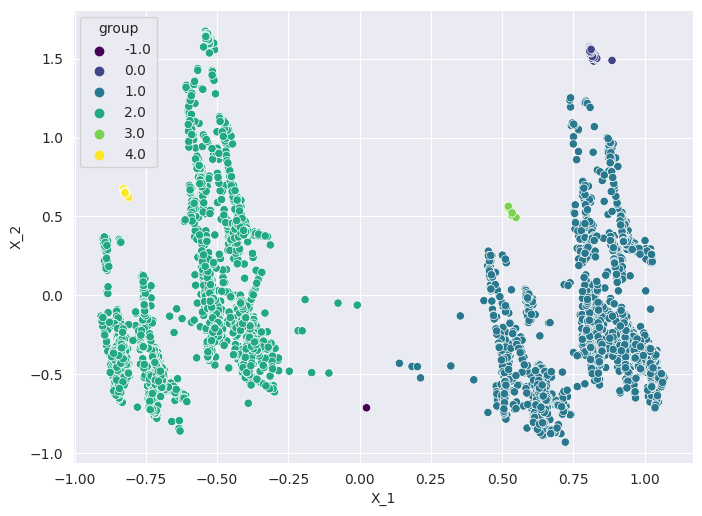

In [45]:
df_pca=pd.DataFrame(pca_array_train,columns=["X_1","X_2","group"])
plt.figure(figsize=(8,6),dpi=100)
sns.scatterplot(data=df_pca,x="X_1",y="X_2",hue='group',palette='viridis')
plt.show()

In [46]:
label_array=pca_array_train[:,-1]
dict_array={}

for label in label_array:
  if label in dict_array:
    dict_array[label]+=1
  else:
    dict_array[label]=1

dict_array

{0.0: 228, 1.0: 2621, 2.0: 3943, 3.0: 21, 4.0: 18, -1.0: 1}

In [47]:
X_train_cluster_out=pd.DataFrame(X_train_cluster)
X_train_cluster_out=X_train_cluster_out.rename(columns={17:'label'})
X_train_cluster_out=X_train_cluster_out[(X_train_cluster_out['label']!=-1) & (X_train_cluster_out['label']!=4)]

y_train=y_train[X_train_cluster_out.index]

## Logistic Regression with clustering

In [55]:
from sklearn.linear_model import LogisticRegression

log_model=LogisticRegression(solver='saga',random_state=42)

c=[0.001,0.01,0.1,1,10,100]
l1_ratio=np.linspace(0.2,0.5,20)
penalty=['l1', 'l2', 'elasticnet', 'none']

f_beta_score = make_scorer(fbeta_score, beta=0.5)


params={'C': c, 'l1_ratio': l1_ratio, 'penalty':penalty}
gridi_model=GridSearchCV(log_model,params,cv=4,scoring=f_beta_score)


In [56]:
gridi_model.fit(X_train_cluster_out,y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(random_state=42, solver='saga'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0.2       , 0.21578947, 0.23157895, 0.24736842, 0.26315789,
       0.27894737, 0.29473684, 0.31052632, 0.32631579, 0.34210526,
       0.35789474, 0.37368421, 0.38947368, 0.40526316, 0.42105263,
       0.43684211, 0.45263158, 0.46842105, 0.48421053, 0.5       ]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring=make_scorer(fbeta_score, beta=0.5))

In [57]:
gridi_model.best_estimator_

LogisticRegression(C=1, l1_ratio=0.2, random_state=42, solver='saga')

In [58]:
y_pred=gridi_model.predict(X_test_cluster)

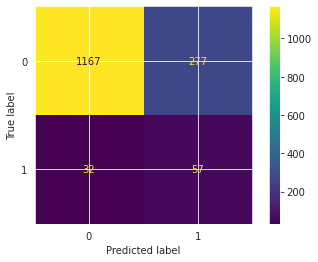

In [59]:
plot_confusion_matrix(gridi_model,X_test_cluster,y_test)

In [60]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1199
           1       0.64      0.17      0.27       334

    accuracy                           0.80      1533
   macro avg       0.72      0.57      0.58      1533
weighted avg       0.77      0.80      0.75      1533



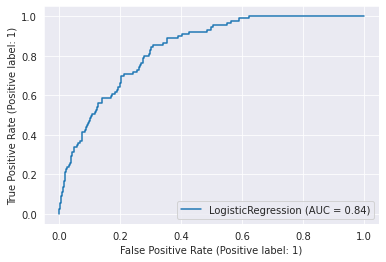

In [61]:
plot_roc_curve(gridi_model.best_estimator_,X_test_cluster,y_test)

### Predict proba

we can play with the logistic regression threshold to may be improve on f1-score at the this model evaluation score

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train,gridi_model.predict_proba(X_train_cluster_out)[:,1],drop_intermediate=False)

thresholds[np.argmin(np.abs(fpr+tpr-1))]

0.5770134590365262

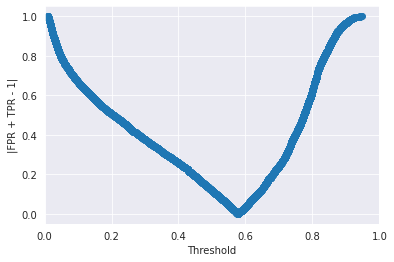

In [ ]:
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.xlim(0,1)
plt.show()

In [ ]:
y_predict_prob=gridi_model.predict_proba(X_test_cluster)
y_predict_prob_class_1 = y_predict_prob[:,1]
y_predict_class =[ 1 if prob>=0.6 else 0 for prob in y_predict_prob_class_1]
print(classification_report(y_predict_class,y_test))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1234
           1       0.58      0.17      0.27       299

    accuracy                           0.81      1533
   macro avg       0.71      0.57      0.58      1533
weighted avg       0.78      0.81      0.77      1533



# **Conclusion**

**I based my decision using the f1-score as a scoring metric because I'm  dealing with imbalance data** - It basicly means I'm ignoring True Negetive on my calculation because it increases significally the scores of the model while it's not really challanging the model to "guess" right on a person not to be found with stroke and to be right

Now the decision is really difficult here because the scores of those model is really tight:

*   DecisionTree - 0.25
*   logistic Regressin - 0.27

while both scores are consider to be quit poor


Now becasue the diffrences between this models is tiny (0.02) I think any of them can be chosen depend on our purposes of this project:


*   If we are considering the best model by score as the best model for us including True Negetive results, and decreasing the amount of the false positive results, we should choose the **logistic regression model** we can also see that when adding the True Negetives result the gap between those model is increasing (by AUC graph)
*   If we are looking to decreasing the amount of False Negetive results (as trade off of increasing False Positive) we should choose the **DecisionTree** model

